In [1]:
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(4)
#numpyro.set_platform('gpu') # set it to cpu and increase the number of devices if required

In [2]:
from jax.tree_util import tree_flatten, tree_map, tree_reduce
from data import get_history_dict, get_tier_sorted

history = get_history_dict()

# MOCK LOSER Q DYNAMICS

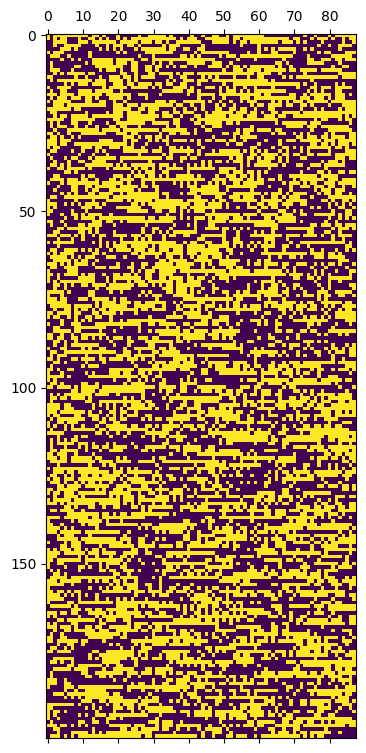

In [4]:
import matplotlib.pyplot as plt
from model import generate_obvious_loser_q
mock_history = generate_obvious_loser_q()
plt.matshow(mock_history);

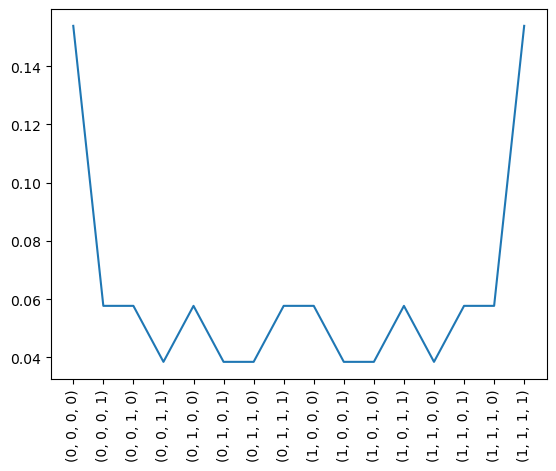

In [3]:
stat_distribution = markov_util_ref.stationary_distribution(probs)
states = markov_util_ref.get_states()
plt.plot([str(x) for x in states], stat_distribution)
plt.xticks(rotation=90);

In [8]:
import arviz as az 
import tensorflow_probability.substrates.jax.distributions as tfd
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey

dict_of_id = {}

for i in range(8, -1, -1):
    
    markov_util = DTMCModel(i)

    def model():
        
        if i != 0: 
            proba = numpyro.sample('proba', dist.Uniform(low=jnp.zeros(2**markov_util.n), high=jnp.ones(2**markov_util.n)))
        else:
            proba = numpyro.sample('proba', dist.Uniform(low=0, high=1))*jnp.ones(2**markov_util.n)
            
        transition_matrix = markov_util.build_transition_matrix(proba)
        
        def transition_fn(_, x):
            return tfd.Categorical(probs=transition_matrix[x])
        
        encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, mock_history)
        
        likelihood_dist = tfd.MarkovChain(
                initial_state_prior=tfd.Categorical(probs=markov_util.uniform_prior),
                transition_fn=transition_fn,
                num_steps=encoded_history.shape[1]
        )
        
        numpyro.sample('likelihood', likelihood_dist, obs=encoded_history)

    kernel = NUTS(model)
    num_samples = 2000
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4, chain_method='vectorized')
    mcmc.run(PRNGKey(0))
    
    dict_of_id[str(i)] = az.from_numpyro(mcmc)
    
    assert np.all(az.rhat(dict_of_id[str(i)])<1.01)

sample: 100%|██████████| 3000/3000 [00:14<00:00, 208.50it/s]


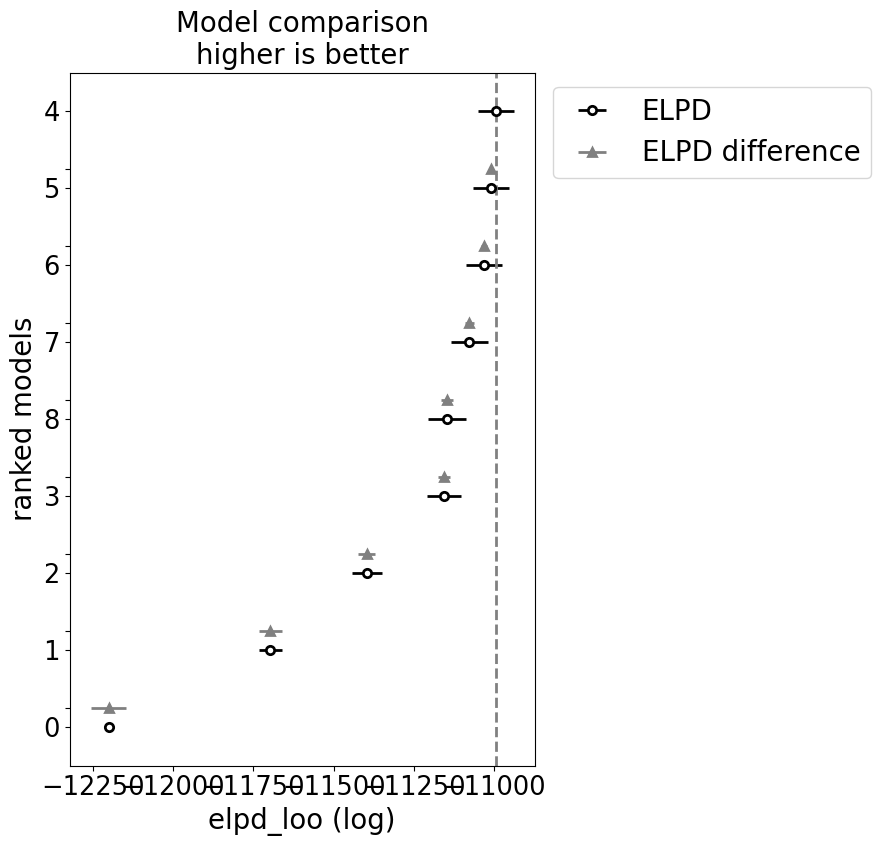

In [9]:
az.plot_compare(az.compare(dict_of_id));

In [ ]:
import pandas as pd 
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['4']
samples = np.asarray(az.extract(best_id).proba)

dict_of_samples = {str(state) + '-> (1)':samples[i] for i, state in enumerate(markov_util_ref.get_states())}

cc = ChainConsumer()
cc.add_chain(Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name='ref'))
cc.add_truth(Truth(location={str(state) + '-> (1)':probs_keys[sum(state)/4] for i, state in enumerate(markov_util_ref.get_states())}, line_style=":", color="red"))
cc.plotter.plot()
plt.show()
#plt.savefig('test_summaries_corner.png', bbox_inches='tight')

"""
cc.plotter.plot_summary()
plt.tight_layout()
plt.savefig('test_summaries.png', bbox_inches='tight')
"""

# SOFT LOSERQ

In [ ]:
import numpy as np 
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey
from model import DTMCModel

markov_util_ref = DTMCModel(4)

probs = jnp.empty((2**4))
probs_keys = {0. : 0.25, 0.25:1/3, 0.5:0.5, 0.75:2/3, 1.:0.75}

for i, state in enumerate(markov_util_ref.get_states()):
    probs = probs.at[i].set(probs_keys[sum(state)/4])
    
mock_history_encoded = markov_util_ref.build_process(85, probs=probs).sample(200, seed=PRNGKey(42))
mock_history = np.apply_along_axis(markov_util_ref.categorical_serie_to_binary, 1, mock_history_encoded)
plt.matshow(mock_history);

In [49]:
from jax.random import split
from tqdm.notebook import tqdm

key_ref = PRNGKey(42)

mock_history_list = []
importance_list = []

for history_in_tier in list(history.values())[0:8]:

    for puuid, true_history in tqdm(history_in_tier.items()):

        key, key_ref = split(key_ref, 2)

        probs = jnp.empty((2**4))

        importance = pert(0, 0.05, 1) #np.random.beta(a=2, b=5)
        probs_keys = {0. : 0.5 - 0.375*importance, 
                      0.25:0.5 - 0.125*importance, 
                      0.5:0.5, 
                      0.75:0.5 + 0.125*importance, 
                      1.:0.5 + 0.375*importance}
        
        for i, state in enumerate(markov_util_ref.get_states()):
            probs = probs.at[i].set(probs_keys[sum(state)/4])
            
        mock_history_encoded = markov_util_ref.build_process(85, probs=probs).sample(1, seed=key)[0]
        mock_history = markov_util_ref.categorical_serie_to_binary(mock_history_encoded)

        mock_history_list.append(mock_history)
        importance_list.append(importance)

# plt.matshow(np.asarray(mock_history_list)[np.argsort(importance_list)]);

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [3]:
import jax 
from tensorflow_probability.substrates.jax import distributions as tfd

In [4]:
from leaguedata.model import generate_coinflip_history, DTMCModel
mock_history = generate_coinflip_history()

In [7]:
import arviz as az 
import numpy as np
import jax.numpy as jnp
import tensorflow_probability.substrates.jax.distributions as tfd
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey
from leaguedata.inference import numpyro_model

dict_of_id = {}

for i in range(4, -1, -1):
    
    markov_util = DTMCModel(i)
    kernel = NUTS(numpyro_model)
    num_samples = 2000
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4, chain_method='parallel')#'vectorized')
    mcmc.run(PRNGKey(0), markov_util, mock_history)
    
    dict_of_id[str(i)] = az.from_numpyro(mcmc)
    
    assert np.all(az.rhat(dict_of_id[str(i)])<1.01)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

/Users/sdupourque/opt/anaconda3/envs/truskill2/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/sdupourque/opt/anaconda3/envs/truskill2/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/sdupourque/opt/anaconda3/envs/truskill2/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

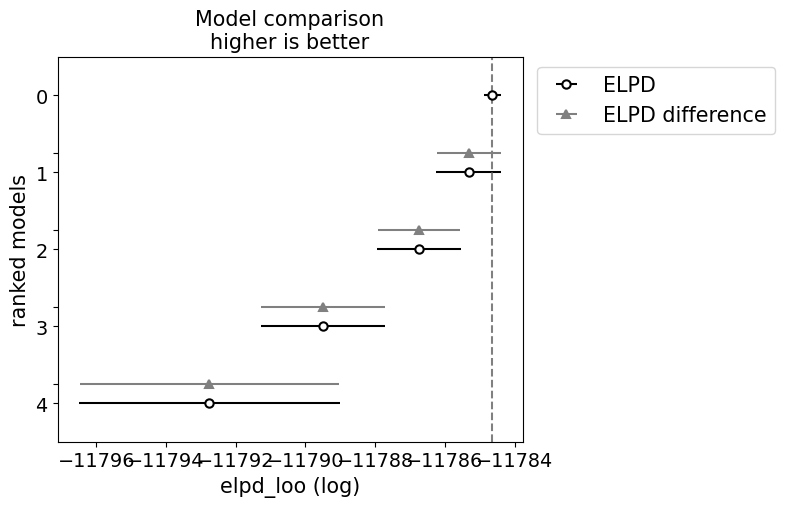

In [8]:
az.plot_compare(az.compare(dict_of_id));

# TRUE DATA

sample: 100%|██████████| 3000/3000 [01:03<00:00, 47.44it/s]


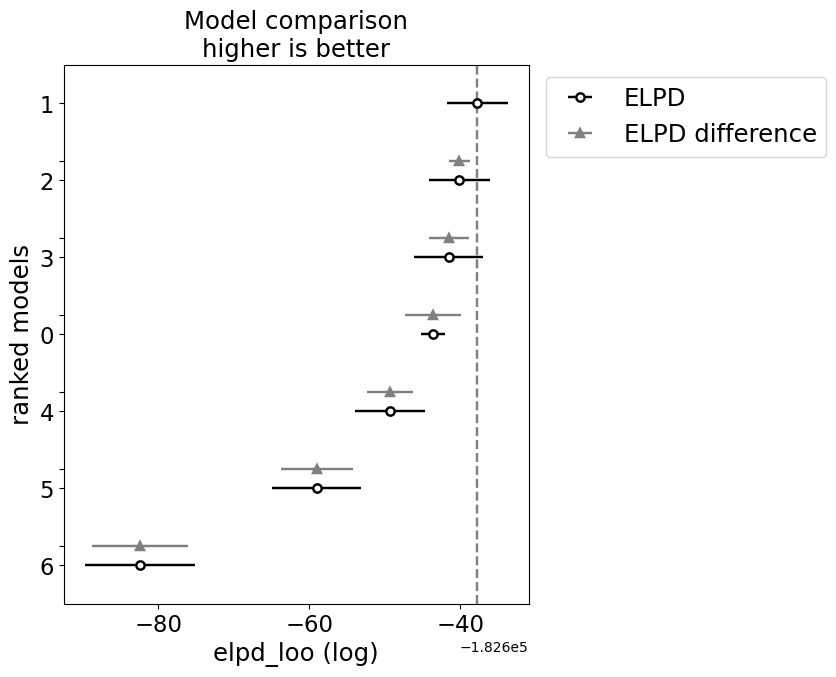

In [53]:
import arviz as az 
import jax
from numpyro.infer import MCMC, NUTS
from jax.random import PRNGKey

tier_list = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'EMERALD', 'DIAMOND', 'MASTER', 'GRANDMASTER',
             'CHALLENGER']

dict_of_id = {}

local_history = history
smallest_history_size = tree_reduce(min, tree_map(lambda x: x.shape[0], local_history))
flat_tree, _ = tree_flatten(tree_map(lambda x: x[-smallest_history_size:], local_history))
observed_history = jnp.asarray(flat_tree)

for i in range(6, -1, -1):
    
    markov_util = DTMCModel(i)
    encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)
    encoded_history = jax.device_put(encoded_history)

    def model():
        
        if i != 0: 
            proba = numpyro.sample('proba', dist.Uniform(low=jnp.zeros(2**markov_util.n), high=jnp.ones(2**markov_util.n)))
        else:
            proba = numpyro.sample('proba', dist.Uniform(low=0, high=1))*jnp.ones(2**markov_util.n)
                
        transition_matrix = markov_util.build_transition_matrix(proba)
        
        def transition_fn(_, x):
            return tfd.Categorical(probs=transition_matrix[x])
        
        encoded_history = np.apply_along_axis(markov_util.binary_serie_to_categorical, 1, observed_history)
        
        likelihood_dist = tfd.MarkovChain(
                initial_state_prior=tfd.Categorical(probs=markov_util.uniform_prior),
                transition_fn=transition_fn,
                num_steps=encoded_history.shape[1]
        )
        
        numpyro.sample('likelihood', likelihood_dist, obs=encoded_history)

    kernel = NUTS(model)
    num_samples = 2000
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=4, chain_method='vectorized')
    mcmc.run(
        PRNGKey(0)
    )
    
    dict_of_id[str(i)] = az.from_numpyro(mcmc)

az.plot_compare(az.compare(dict_of_id));

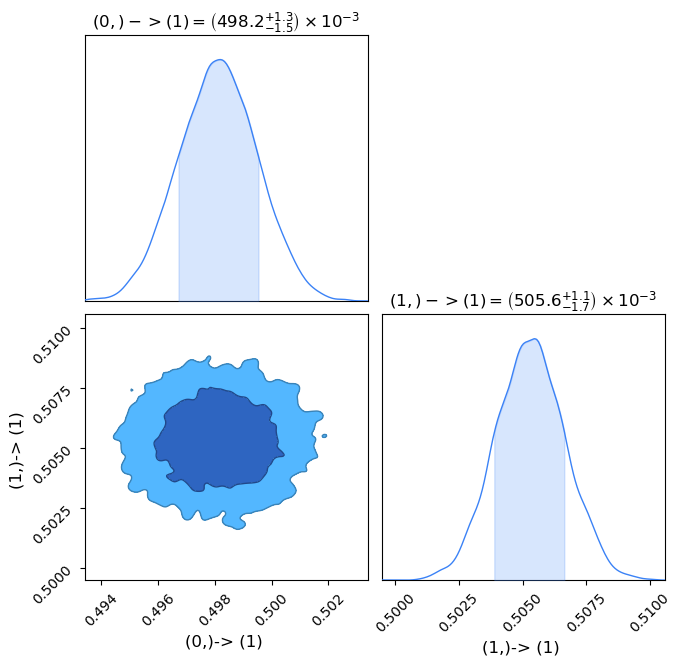

"\ncc.plotter.plot_summary()\nplt.tight_layout()\nplt.savefig('test_summaries.png', bbox_inches='tight')\n"

In [67]:
import pandas as pd 
from chainconsumer import ChainConsumer, Chain, Truth

best_id = dict_of_id['1']
markov_util = DTMCModel(1)
samples = np.asarray(az.extract(best_id).proba)

dict_of_samples = {str(state) + '-> (1)':samples[i] for i, state in enumerate(markov_util.get_states())}

cc = ChainConsumer()
cc.add_chain(Chain(samples=pd.DataFrame.from_dict(dict_of_samples), name='ref'))
cc.plotter.plot()
plt.show()
#plt.savefig('test_summaries_corner.png', bbox_inches='tight')

"""
cc.plotter.plot_summary()
plt.tight_layout()
plt.savefig('test_summaries.png', bbox_inches='tight')
"""

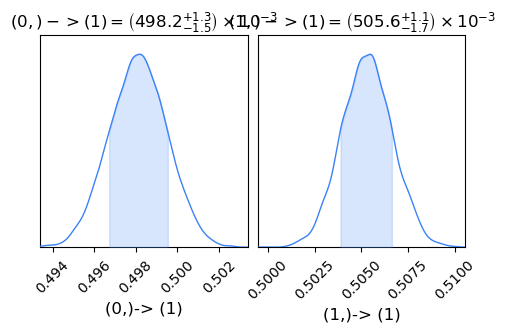

In [69]:
cc.plotter.plot_distributions();